In [11]:
# Core utilities moved to fire_model package
import numpy as np
import matplotlib.pyplot as plt
from fire_model.ca import FireEnv, FireState, CAFireModel
from fire_model.boundary import (
    FireBoundary,
    between_boundaries_mask,
    candidates_from_mask,
    extract_fire_boundary,
    plot_fire_boundary,
)
from fire_model.harmonic import (
    HarmonicStripMap,
    BoundaryMap,
    build_harmonic_strip_map_uniform,
    plot_strip_map,
    sd_to_xy_theta,
    build_boundary_map,
    plot_boundary_correspondence,
)
from fire_model.bo import (
    RetardantDropBayesOpt,
    SearchGridProjector,
    TiedXYFiMatern,
    expected_improvement,
)

import fire_model.bo as bo

### Environment Set-Up incl. a Small, High-Value Asset (e.g. Town or Property)

In [12]:
# Grid / domain
nx = ny = 120
domain_km = 5

# Time discretisation (used for indexing time-varying wind and for FireState.t)
dt_s = 5.0

# Fire physics parameters
burn_time_s0 = 15 * 60         # how long a cell stays "burning" after ignition (seconds)
ros_mps = 0.25                 # baseline ROS (m/s)

# Retardant parameters
retardant_half_life_s = 2400.0 # seconds (e.g., 40 minutes)
retardant_k = 1.25             # attenuation strength exp(-k * retardant)

# Spatial maps
xs = np.linspace(-1.0, 1.0, nx)[:, None]
ys = np.linspace(-1.0, 1.0, ny)[None, :]
fuel = 0.7 + 0.9 * np.exp(-3.0 * (xs**2 + ys**2))
fuel = np.ones((nx, ny), dtype=float)
value = 1.0 + 10.0 * np.exp(-15.0 * ((xs+0.5) ** 2 + (ys - 0.25) ** 2))

# Constant wind: mild south-westerly
wind=np.zeros((nx, ny, 2), dtype=float)
wind[..., 0] = -5
wind[..., 1] = 15.0  # 5 m/s northwards

env = FireEnv(
    grid_size=(nx, ny),
    domain_km=domain_km,
    wind=wind,
    fuel=fuel,
    value=value,
    dt_s=dt_s,
    burn_time_s0=burn_time_s0,
    retardant_half_life_s=retardant_half_life_s,
    retardant_k=retardant_k,
    ros_mps=ros_mps,
    # wind_coeff is unused by the Finsler model, but can exist in the env
    wind_coeff=0.6,
    diag=True,
    avoid_burning_drop=True,
    avoid_drop_p_threshold=0.25,
)

ca_model = CAFireModel(env,seed=42)

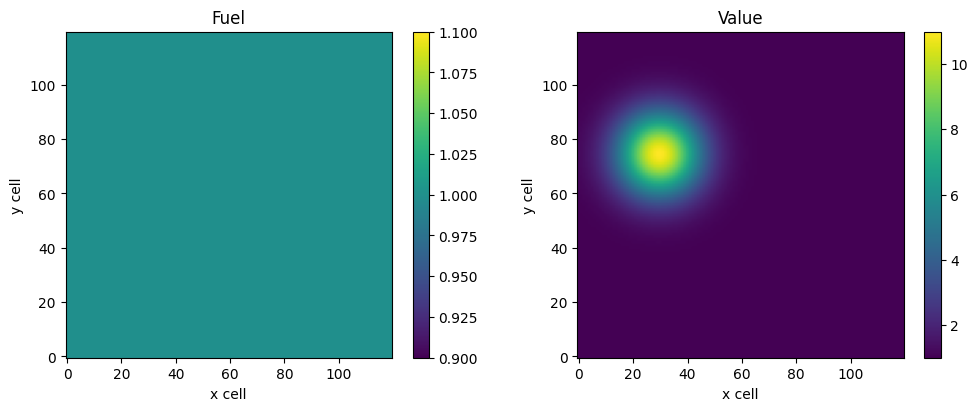

In [13]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), constrained_layout=True)

im0 = ax[0].imshow(fuel.T, origin="lower", aspect="equal")
ax[0].set_title("Fuel")
ax[0].set_xlabel("x cell"); ax[0].set_ylabel("y cell")
fig.colorbar(im0, ax=ax[0], fraction=0.046)

im1 = ax[1].imshow(value.T, origin="lower", aspect="equal")
ax[1].set_title("Value")
ax[1].set_xlabel("x cell"); ax[1].set_ylabel("y cell")
fig.colorbar(im1, ax=ax[1], fraction=0.046)

plt.show()

### Ignition and Search Domain - Here fire is already significant at time-of-arrival

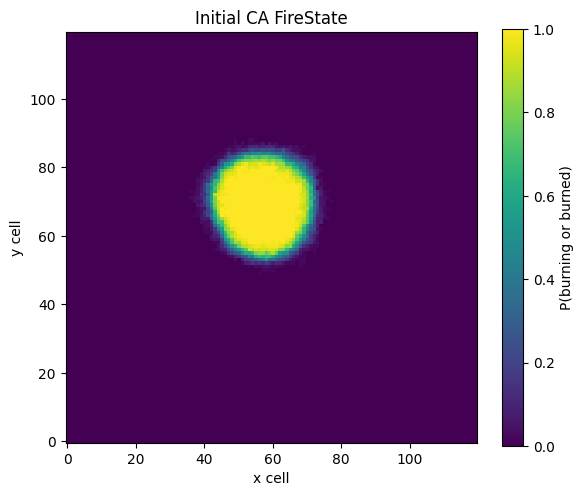

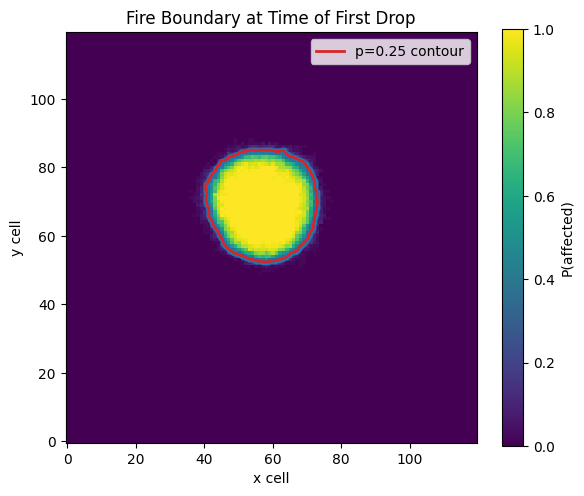

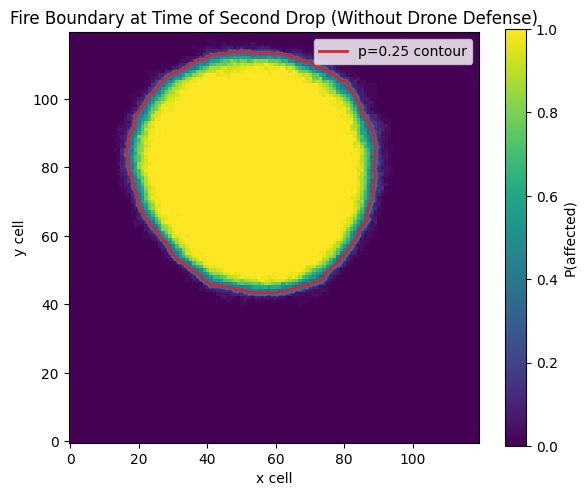

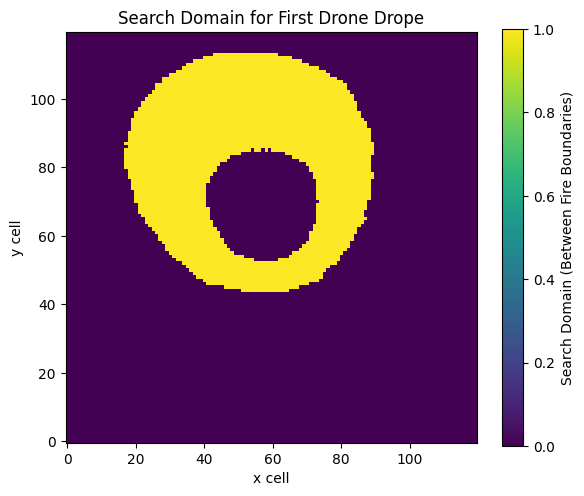

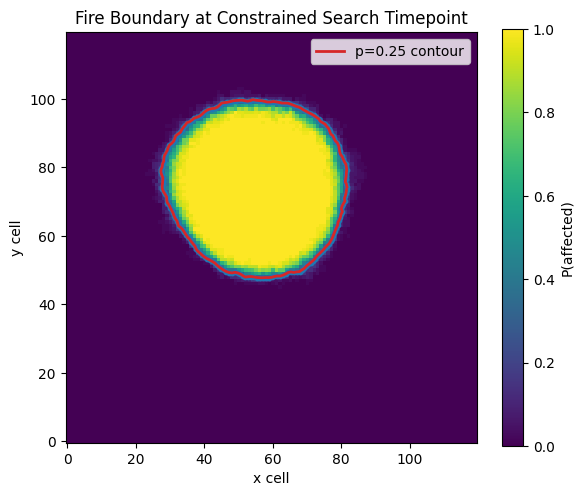

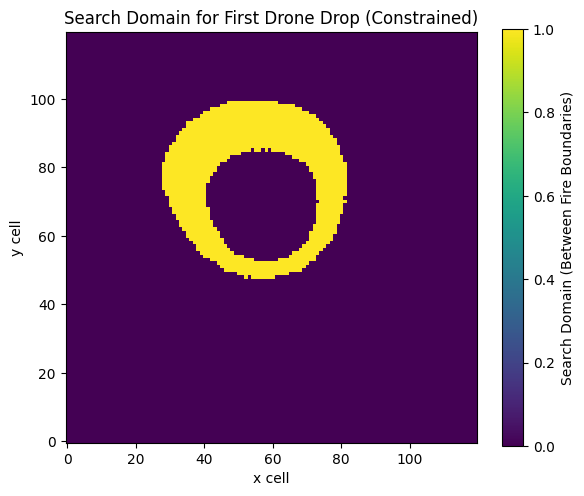

In [14]:
# Ignition and time until drones reach the fire
ignition_center = (nx // 2, ny // 2)
ignition_radius_km = 0.01
time_to_first_drop = 150.0  
time_to_second_drop = 310.0 #
search_space_time = (time_to_second_drop - time_to_first_drop)//2

# Initial Evolution
init_firestate_ca = ca_model.simulate_from_ignition(
    center=ignition_center,
    radius_km=ignition_radius_km,
    n_sims=50,
    T=time_to_first_drop
)

ca_model.plot_firestate(init_firestate_ca,title="Initial CA FireState")

# Visualising the boundary
init_boundary = extract_fire_boundary(
    init_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    init_firestate_ca,
    init_boundary,
    field="affected",
    title="Fire Boundary at Time of First Drop"
)

# Visualising the search domain
second_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=time_to_second_drop - time_to_first_drop, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

second_boundary = extract_fire_boundary(
    second_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    second_firestate_ca,
    second_boundary,
    field="affected",
    title="Fire Boundary at Time of Second Drop (Without Drone Defense)"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, second_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drope")

# Extra constrained search space

constrained_firestate_ca = ca_model.simulate_from_firestate(
    init_firestate=init_firestate_ca,
    T=search_space_time, # assumes we want to search the whole space between first & second drop (smaller might be better in practice)
    n_sims=50,
)

constrained_boundary = extract_fire_boundary(
    constrained_firestate_ca,  
    K=200,
    p_boundary=0.25,
    field="affected",
    anchor="max_x",
    ccw=True
)

plot_fire_boundary(
    constrained_firestate_ca,
    constrained_boundary,
    field="affected",
    title="Fire Boundary at Constrained Search Timepoint"
)

between_boundaries_mask = ca_model.discretise_between_boundaries(init_boundary, constrained_boundary)

ca_model.plot_search_domain(between_boundaries_mask,title="Search Domain for First Drone Drop (Constrained)")

### Bayesian Optimisation Set-Up

In [15]:
from fire_model.bo import RetardantDropBayesOpt

constrained_search_time = (time_to_second_drop - time_to_first_drop)*2//3

drop_opt = RetardantDropBayesOpt(
    fire_model=ca_model,
    init_firestate=init_firestate_ca,
    n_drones=4,
    evolution_time_s=time_to_second_drop-time_to_first_drop,
    search_grid_evolution_time_s=constrained_search_time,
    n_sims=50,
    fire_boundary_probability=0.25,
)

[Heuristic] Search grid set up with 1283 valid cells in grid.


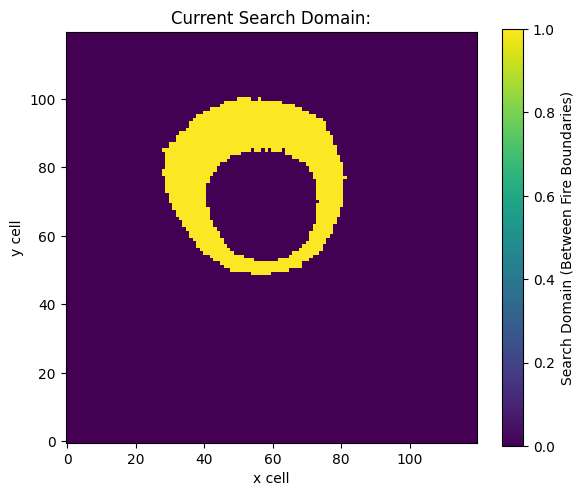

[Heuristic] eval 001/200 | y=10.0345 | best=10.0345
           (x,y,phi) per drone:
           [[38.         63.          3.1366826 ]
 [38.         83.          3.87306706]
 [54.         94.          4.49808167]
 [73.         85.          4.67499728]]
[Heuristic] eval 020/200 | y=10.6922 | best=8.13531
           (x,y,phi) per drone:
           [[39.         62.          2.7303602 ]
 [41.         85.          4.05005715]
 [54.         91.          4.78942391]
 [65.         89.          5.28061827]]
[Heuristic] eval 040/200 | y=9.78677 | best=8.13531
           (x,y,phi) per drone:
           [[38.         66.          3.2874649 ]
 [46.         90.          4.40706559]
 [65.         90.          4.35278814]
 [74.         82.          5.58525464]]
[Heuristic] eval 060/200 | y=10.4307 | best=7.88796
           (x,y,phi) per drone:
           [[35.         74.          4.24775278]
 [47.         89.          4.3422687 ]
 [57.         95.          4.55107433]
 [75.         81.          5.733

In [16]:
best_theta, best_params, best_y, (X_feats, y_arr), y_nexts, y_bests_arr =drop_opt.run_heuristic_search(
    n_evals=200,
    heuristic_random_frac=0.0,
    print_every=20,
)

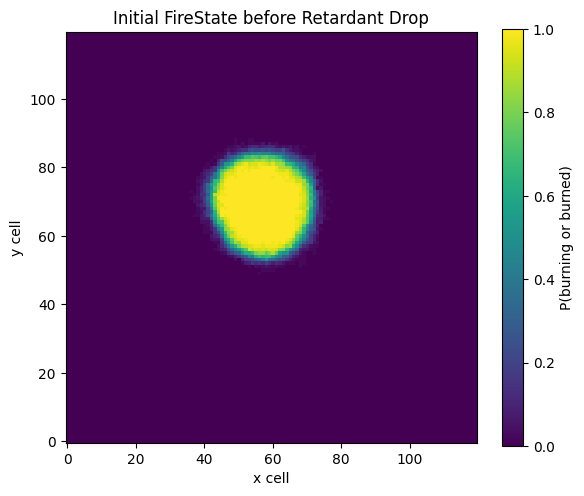

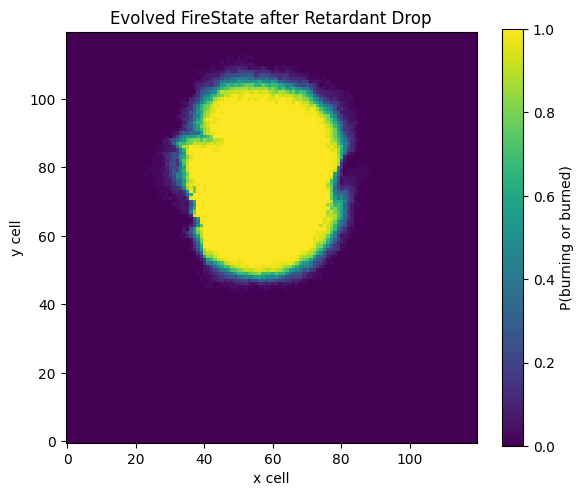

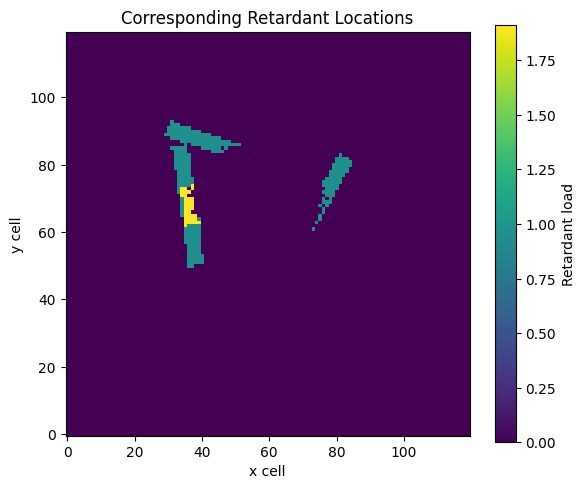

In [17]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Bayesian Optimisation (Random Mask Initialisation)

In [18]:
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="random_mask",
    candidate_strategy="qmc",
    candidate_qmc="sobol",
    print_every=10,
)

[BO] init: n_init=50, dim=12, n_cells=1283
[BO] init: best_y=8.13995, mean_y=10.576, std_y=0.760918
[BO] iter 001/150 | y_next=9.26814 | best_y=8.13995 (no-improve) | EI_max=0.0375 | mu=8.86429 | std=0.628
      proposed (x,y,phi) per drone:
      [[28.         79.          4.83802554]
 [28.         85.          5.59984426]
 [32.         66.          6.2098179 ]
 [79.         66.          1.52634256]]
      gp.kernel_ = 1.74**2 * TiedXYFiMatern(lx=0.44, ly=997, lphi=32.5, nu=2.5) + WhiteKernel(noise_level=0.419)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 010/150 | y_next=9.35316 | best_y=8.13995 (no-improve) | EI_max=0.000819 | mu=10.1698 | std=0.757
      proposed (x,y,phi) per drone:
      [[28.         79.          1.25964235]
 [28.         85.          2.73829437]
 [28.         85.          4.40519885]
 [30.         70.          6.25136374]]
      gp.kernel_ = 0.951**2 * TiedXYFiMatern(lx=0.304, ly=1e+03, lphi=22, nu=2.5) + WhiteKernel(noise_level=0.481)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 020/150 | y_next=9.71202 | best_y=8.13995 (no-improve) | EI_max=0.0337 | mu=8.58371 | std=0.437
      proposed (x,y,phi) per drone:
      [[29.         73.          4.0928711 ]
 [35.         76.          3.91287865]
 [44.         61.          5.884766  ]
 [58.         85.          5.03631361]]
      gp.kernel_ = 1.22**2 * TiedXYFiMatern(lx=1.83, ly=0.194, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.136)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 030/150 | y_next=10.0981 | best_y=8.13995 (no-improve) | EI_max=0.000673 | mu=9.54266 | std=0.534
      proposed (x,y,phi) per drone:
      [[28.         78.          2.8053945 ]
 [28.         78.          5.92161443]
 [28.         85.          0.10672458]
 [62.         99.          6.12279921]]
      gp.kernel_ = 1.27**2 * TiedXYFiMatern(lx=0.51, ly=7.08, lphi=22.5, nu=2.5) + WhiteKernel(noise_level=0.399)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 040/150 | y_next=10.1082 | best_y=8.13995 (no-improve) | EI_max=0.000308 | mu=9.6044 | std=0.514
      proposed (x,y,phi) per drone:
      [[28.         85.          2.21579616]
 [29.         82.          5.10799178]
 [36.         60.          1.58550317]
 [37.         94.          5.75470064]]
      gp.kernel_ = 1.11**2 * TiedXYFiMatern(lx=0.407, ly=146, lphi=30.9, nu=2.5) + WhiteKernel(noise_level=0.395)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 050/150 | y_next=10.1753 | best_y=8.13995 (no-improve) | EI_max=0.000254 | mu=9.64462 | std=0.517
      proposed (x,y,phi) per drone:
      [[28.         85.          5.11459025]
 [32.         66.          4.97864406]
 [34.         63.          2.31548046]
 [80.         69.          0.56447154]]
      gp.kernel_ = 1.1**2 * TiedXYFiMatern(lx=0.403, ly=805, lphi=20.4, nu=2.5) + WhiteKernel(noise_level=0.376)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=9.03425 | best_y=8.13995 (no-improve) | EI_max=0.000382 | mu=9.47381 | std=0.482
      proposed (x,y,phi) per drone:
      [[2.80000000e+01 7.80000000e+01 4.67868195e+00]
 [2.90000000e+01 7.30000000e+01 5.29796935e+00]
 [3.30000000e+01 9.00000000e+01 4.42733154e+00]
 [4.00000000e+01 5.50000000e+01 7.09117472e-02]]
      gp.kernel_ = 1.11**2 * TiedXYFiMatern(lx=0.389, ly=59.8, lphi=17.3, nu=2.5) + WhiteKernel(noise_level=0.358)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 070/150 | y_next=9.53014 | best_y=8.13995 (no-improve) | EI_max=0.000245 | mu=9.55163 | std=0.487
      proposed (x,y,phi) per drone:
      [[28.         85.          6.2199627 ]
 [30.         70.          4.34221264]
 [30.         87.          3.26335093]
 [32.         89.          4.67463487]]
      gp.kernel_ = 1.07**2 * TiedXYFiMatern(lx=0.381, ly=1e+03, lphi=18.6, nu=2.5) + WhiteKernel(noise_level=0.362)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 080/150 | y_next=8.71011 | best_y=8.13995 (no-improve) | EI_max=0.00171 | mu=9.07313 | std=0.417
      proposed (x,y,phi) per drone:
      [[28.         78.          4.88736061]
 [29.         73.          5.32582425]
 [29.         73.          6.07530562]
 [34.         63.          3.41984009]]
      gp.kernel_ = 1.67**2 * TiedXYFiMatern(lx=0.937, ly=0.417, lphi=35.3, nu=2.5) + WhiteKernel(noise_level=0.236)
[BO] iter 090/150 | y_next=9.57817 | best_y=8.13995 (no-improve) | EI_max=0.000535 | mu=9.20496 | std=0.408
      proposed (x,y,phi) per drone:
      [[28.         85.          2.19188808]
 [29.         73.          4.0174323 ]
 [31.         68.          3.68816712]
 [60.         85.          1.15333971]]
      gp.kernel_ = 1.62**2 * TiedXYFiMatern(lx=0.909, ly=0.368, lphi=51.4, nu=2.5) + WhiteKernel(noise_level=0.206)
[BO] iter 100/150 | y_next=9.68174 | best_y=8.13995 (no-improve) | EI_max=0.000397 | mu=9.27812 | std=0.42
      proposed (x,y,phi) per drone:
      [[29. 

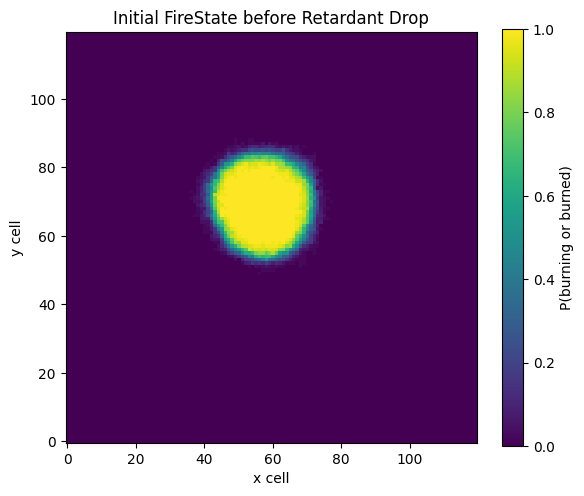

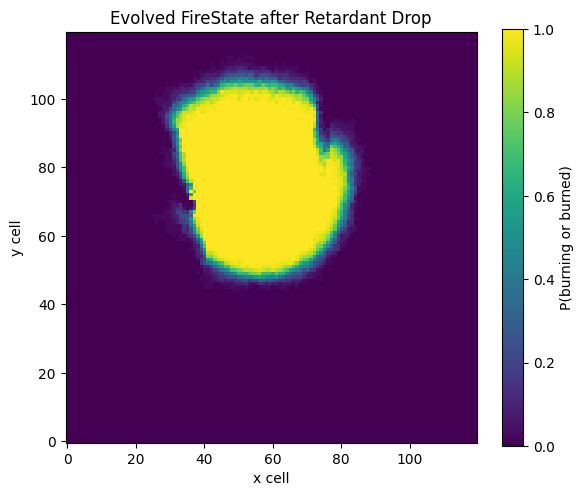

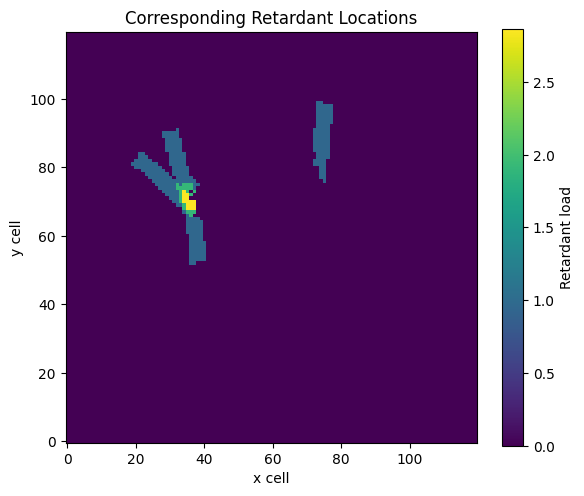

In [19]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Bayesian Optimisation (Heuristic + Random Initialisation)

In [20]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12,
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="qmc",
    candidate_qmc="sobol",
)

[BO] init: n_init=50, dim=12, n_cells=1284
[BO] init: best_y=8.23564, mean_y=10.0988, std_y=0.937399


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 001/150 | y_next=10.2189 | best_y=8.23564 (no-improve) | EI_max=0.195 | mu=8.48819 | std=0.773
      proposed (x,y,phi) per drone:
      [[28.         78.          2.52367239]
 [38.         95.          3.19147746]
 [59.         49.          5.72433911]
 [74.         56.          3.15915927]]
      gp.kernel_ = 1.1**2 * TiedXYFiMatern(lx=0.124, ly=1e+03, lphi=3.28, nu=2.5) + WhiteKernel(noise_level=0.112)
[BO] iter 010/150 | y_next=9.95168 | best_y=8.23564 (no-improve) | EI_max=0.0164 | mu=9.5822 | std=0.816
      proposed (x,y,phi) per drone:
      [[28.         79.          5.71502098]
 [38.         95.          0.20893309]
 [39.         56.          5.98485607]
 [47.         99.          2.28382376]]
      gp.kernel_ = 0.979**2 * TiedXYFiMatern(lx=0.0642, ly=0.2, lphi=2.55, nu=2.5) + WhiteKernel(noise_level=4.68e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 020/150 | y_next=9.78292 | best_y=8.23564 (no-improve) | EI_max=0.0145 | mu=9.47449 | std=0.745
      proposed (x,y,phi) per drone:
      [[31.         68.          2.42238037]
 [33.         90.          1.56640167]
 [48.         50.          0.90956807]
 [70.         96.          5.31890304]]
      gp.kernel_ = 0.958**2 * TiedXYFiMatern(lx=0.059, ly=0.173, lphi=4.06, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 030/150 | y_next=9.46229 | best_y=8.23564 (no-improve) | EI_max=0.0149 | mu=9.35081 | std=0.69
      proposed (x,y,phi) per drone:
      [[33.         79.          4.76117857]
 [38.         86.          6.10870113]
 [61.         85.          0.66130054]
 [80.         78.          1.17758029]]
      gp.kernel_ = 0.952**2 * TiedXYFiMatern(lx=0.0551, ly=0.114, lphi=893, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/si

[BO] iter 040/150 | y_next=9.73484 | best_y=8.23564 (no-improve) | EI_max=0.0255 | mu=9.16922 | std=0.679
      proposed (x,y,phi) per drone:
      [[28.         79.          0.99993541]
 [28.         85.          6.06562423]
 [31.         68.          1.36904796]
 [46.         82.          4.5623663 ]]
      gp.kernel_ = 0.941**2 * TiedXYFiMatern(lx=0.0671, ly=0.101, lphi=7.22, nu=2.5) + WhiteKernel(noise_level=1e-06)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:440: ConvergenceWarning: The optimal value found for dimension 0 of parameter k2__noise_level is close to the specified lower bound 1e-06. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packa

[BO] iter 050/150 | y_next=9.4892 | best_y=8.23564 (no-improve) | EI_max=0.0152 | mu=9.1242 | std=0.581
      proposed (x,y,phi) per drone:
      [[28.         85.          3.5282531 ]
 [29.         73.          5.01154112]
 [30.         87.          2.77386898]
 [36.         93.          2.84625384]]
      gp.kernel_ = 0.805**2 * TiedXYFiMatern(lx=0.0856, ly=791, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.431)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 060/150 | y_next=9.65395 | best_y=8.23564 (no-improve) | EI_max=0.00814 | mu=9.35213 | std=0.616
      proposed (x,y,phi) per drone:
      [[28.         79.          4.21486371]
 [28.         85.          5.45333624]
 [29.         73.          1.1882968 ]
 [40.         55.          5.25149862]]
      gp.kernel_ = 0.762**2 * TiedXYFiMatern(lx=0.098, ly=0.486, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.44)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


[BO] iter 070/150 | y_next=9.22324 | best_y=8.23564 (no-improve) | EI_max=0.00955 | mu=9.23174 | std=0.578
      proposed (x,y,phi) per drone:
      [[28.         78.          1.53708481]
 [29.         73.          2.96158981]
 [36.         60.          4.93776008]
 [36.         60.          6.18191466]]
      gp.kernel_ = 0.747**2 * TiedXYFiMatern(lx=0.109, ly=0.582, lphi=19.7, nu=2.5) + WhiteKernel(noise_level=0.484)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 080/150 | y_next=8.37899 | best_y=8.23564 (no-improve) | EI_max=0.0113 | mu=9.15808 | std=0.561
      proposed (x,y,phi) per drone:
      [[32.         66.          2.87887799]
 [32.         66.          3.24453306]
 [33.         90.          6.27989124]
 [38.         57.          3.17701547]]
      gp.kernel_ = 0.942**2 * TiedXYFiMatern(lx=0.122, ly=0.219, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.286)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 090/150 | y_next=8.79421 | best_y=8.23564 (no-improve) | EI_max=0.0078 | mu=9.23944 | std=0.56
      proposed (x,y,phi) per drone:
      [[28.         78.          4.09938015]
 [32.         66.          5.22263453]
 [33.         90.          3.13891005]
 [40.         71.          4.47725923]]
      gp.kernel_ = 1.18**2 * TiedXYFiMatern(lx=0.363, ly=0.336, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.403)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 100/150 | y_next=8.73699 | best_y=8.23564 (no-improve) | EI_max=0.014 | mu=9.04902 | std=0.532
      proposed (x,y,phi) per drone:
      [[30.         70.          0.95388402]
 [31.         68.          5.28740593]
 [31.         84.          3.15075103]
 [32.         66.          6.06423907]]
      gp.kernel_ = 1.1**2 * TiedXYFiMatern(lx=0.308, ly=0.376, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.415)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 110/150 | y_next=9.23849 | best_y=8.23564 (no-improve) | EI_max=0.00639 | mu=9.18215 | std=0.516
      proposed (x,y,phi) per drone:
      [[28.         79.          1.2635128 ]
 [29.         73.          0.1644203 ]
 [30.         70.          3.30945765]
 [35.         88.          4.66182759]]
      gp.kernel_ = 1.16**2 * TiedXYFiMatern(lx=0.334, ly=0.385, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.403)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 120/150 | y_next=8.59527 | best_y=8.23564 (no-improve) | EI_max=0.00429 | mu=9.19975 | std=0.49
      proposed (x,y,phi) per drone:
      [[28.         78.          4.94904928]
 [29.         73.          5.39457163]
 [34.         63.          3.31032169]
 [36.         60.          2.30017204]]
      gp.kernel_ = 1.36**2 * TiedXYFiMatern(lx=0.533, ly=0.354, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.383)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 130/150 | y_next=9.46504 | best_y=8.23564 (no-improve) | EI_max=0.00566 | mu=9.14262 | std=0.487
      proposed (x,y,phi) per drone:
      [[28.         85.          1.97210063]
 [30.         70.          0.41605807]
 [30.         70.          2.05344837]
 [32.         66.          1.49180477]]
      gp.kernel_ = 1.65**2 * TiedXYFiMatern(lx=0.75, ly=0.401, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.378)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 140/150 | y_next=10.5881 | best_y=8.23564 (no-improve) | EI_max=0.00455 | mu=9.64046 | std=0.678
      proposed (x,y,phi) per drone:
      [[37.         94.          3.12161081]
 [38.         95.          3.63800964]
 [39.         56.          4.96081698]
 [43.         79.          5.01558854]]
      gp.kernel_ = 1.28**2 * TiedXYFiMatern(lx=0.195, ly=0.304, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.275)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/

[BO] iter 150/150 | y_next=9.91459 | best_y=8.23564 (no-improve) | EI_max=0.00447 | mu=9.08911 | std=0.446
      proposed (x,y,phi) per drone:
      [[30.         71.          4.38836798]
 [30.         87.          4.03665982]
 [31.         68.          4.75263145]
 [32.         66.          5.54381187]]
      gp.kernel_ = 1.32**2 * TiedXYFiMatern(lx=0.226, ly=0.314, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.282)
[BO] done: best_y=8.23564
[BO] best params:
[[3.40000000e+01 7.60000000e+01 6.20247021e-02]
 [3.40000000e+01 8.20000000e+01 4.90171233e-01]
 [3.60000000e+01 6.10000000e+01 5.31689966e+00]
 [4.10000000e+01 8.60000000e+01 3.58963467e+00]]


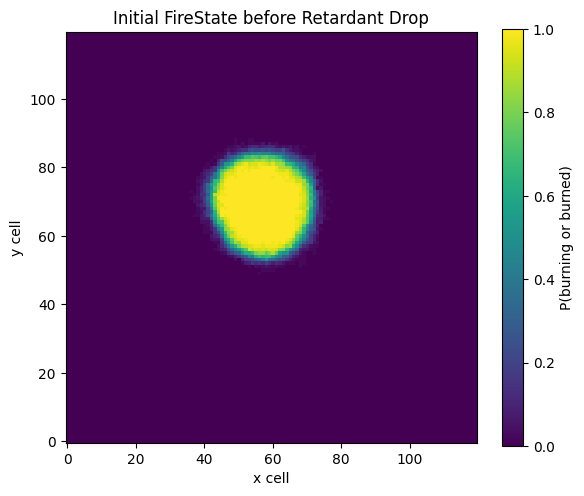

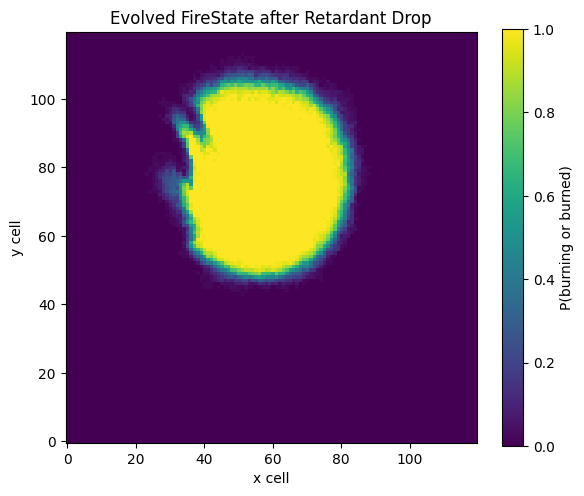

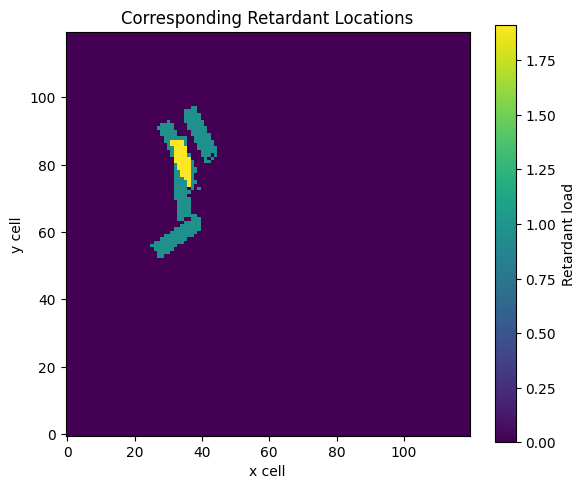

In [21]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

### Heuristic Initialisation and QMC+Local Exploitation (best)

In [22]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=50,
    n_iters=150,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.01, 
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=10,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.6,
    candidate_local_top_k=5,
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
)

[BO] init: n_init=50, dim=12, n_cells=1284
[BO] init: best_y=8.17887, mean_y=10.2323, std_y=0.89952


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/150 | y_next=9.03964 | best_y=8.17887 (no-improve) | EI_max=0.174 | mu=8.22957 | std=0.509
      proposed (x,y,phi) per drone:
      [[29.         80.          6.21085575]
 [34.         63.          6.21942783]
 [36.         88.          0.65123264]
 [76.         87.          1.40331463]]
      gp.kernel_ = 1.03**2 * TiedXYFiMatern(lx=0.194, ly=0.132, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.0858)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/q

[BO] iter 010/150 | y_next=8.96537 | best_y=8.05831 (no-improve) | EI_max=0.0809 | mu=8.36337 | std=0.502
      proposed (x,y,phi) per drone:
      [[2.90000000e+01 7.50000000e+01 7.27474665e-01]
 [3.60000000e+01 6.00000000e+01 7.58211491e-02]
 [3.70000000e+01 8.60000000e+01 1.36255379e-01]
 [7.00000000e+01 9.60000000e+01 7.49430419e-01]]
      gp.kernel_ = 0.867**2 * TiedXYFiMatern(lx=0.207, ly=0.13, lphi=6.87, nu=2.5) + WhiteKernel(noise_level=0.112)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/q

[BO] iter 020/150 | y_next=7.8195 | best_y=7.8195 (improved) | EI_max=0.0341 | mu=8.541 | std=0.463
      proposed (x,y,phi) per drone:
      [[3.30000000e+01 7.70000000e+01 1.95511043e-01]
 [3.40000000e+01 6.30000000e+01 7.04086315e-02]
 [3.50000000e+01 8.00000000e+01 1.79917999e-01]
 [7.40000000e+01 9.40000000e+01 7.18899174e-01]]
      gp.kernel_ = 0.86**2 * TiedXYFiMatern(lx=0.208, ly=0.177, lphi=1e+03, nu=2.5) + WhiteKernel(noise_level=0.163)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__ly is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Docum

[BO] iter 030/150 | y_next=7.43435 | best_y=7.22143 (no-improve) | EI_max=0.0309 | mu=7.37527 | std=0.226
      proposed (x,y,phi) per drone:
      [[3.60000000e+01 6.00000000e+01 5.81189037e-03]
 [3.60000000e+01 8.10000000e+01 1.50632351e-01]
 [3.70000000e+01 7.80000000e+01 6.22558218e+00]
 [7.20000000e+01 9.00000000e+01 8.00210264e-01]]
      gp.kernel_ = 0.835**2 * TiedXYFiMatern(lx=0.0949, ly=1e+03, lphi=1.67, nu=2.5) + WhiteKernel(noise_level=0.0147)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Docum

[BO] iter 040/150 | y_next=7.44741 | best_y=7.07683 (no-improve) | EI_max=0.0673 | mu=7.38172 | std=0.46
      proposed (x,y,phi) per drone:
      [[36.         81.          6.00801407]
 [37.         70.          5.65107336]
 [37.         70.          6.1084447 ]
 [72.         86.          0.91783025]]
      gp.kernel_ = 0.804**2 * TiedXYFiMatern(lx=0.126, ly=0.342, lphi=2.54, nu=2.5) + WhiteKernel(noise_level=0.0472)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 050/150 | y_next=6.99037 | best_y=6.84031 (no-improve) | EI_max=0.0167 | mu=7.42985 | std=0.435
      proposed (x,y,phi) per drone:
      [[36.         76.          6.13524346]
 [37.         71.          6.17447611]
 [37.         72.          0.16471846]
 [68.         90.          0.85949704]]
      gp.kernel_ = 0.793**2 * TiedXYFiMatern(lx=0.141, ly=0.627, lphi=2.84, nu=2.5) + WhiteKernel(noise_level=0.0756)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 060/150 | y_next=7.86637 | best_y=6.84031 (no-improve) | EI_max=0.0143 | mu=7.42924 | std=0.418
      proposed (x,y,phi) per drone:
      [[3.30000000e+01 7.50000000e+01 4.53891351e-02]
 [3.40000000e+01 7.70000000e+01 6.12859349e+00]
 [3.50000000e+01 6.40000000e+01 6.20103459e+00]
 [6.90000000e+01 8.20000000e+01 7.75766253e-01]]
      gp.kernel_ = 0.806**2 * TiedXYFiMatern(lx=0.139, ly=0.472, lphi=2.74, nu=2.5) + WhiteKernel(noise_level=0.051)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 070/150 | y_next=9.38329 | best_y=6.84031 (no-improve) | EI_max=0.0115 | mu=9.06594 | std=1.15
      proposed (x,y,phi) per drone:
      [[28.         85.          1.01564975]
 [28.         85.          2.61494918]
 [30.         70.          2.97298864]
 [33.         90.          4.31505059]]
      gp.kernel_ = 0.821**2 * TiedXYFiMatern(lx=0.129, ly=0.439, lphi=2.64, nu=2.5) + WhiteKernel(noise_level=0.037)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 080/150 | y_next=10.6752 | best_y=6.84031 (no-improve) | EI_max=0.0113 | mu=9.15647 | std=1.19
      proposed (x,y,phi) per drone:
      [[28.         85.          1.71094132]
 [28.         85.          5.11052517]
 [80.         73.          3.51075954]
 [80.         81.          5.24104088]]
      gp.kernel_ = 0.874**2 * TiedXYFiMatern(lx=0.132, ly=0.425, lphi=2.63, nu=2.5) + WhiteKernel(noise_level=0.0256)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 090/150 | y_next=7.34908 | best_y=6.84031 (no-improve) | EI_max=0.0122 | mu=7.1053 | std=0.226
      proposed (x,y,phi) per drone:
      [[35.         73.          5.95159943]
 [35.         77.          6.15183886]
 [36.         74.          0.14861623]
 [69.         93.          0.69285282]]
      gp.kernel_ = 0.9**2 * TiedXYFiMatern(lx=0.137, ly=0.369, lphi=2.53, nu=2.5) + WhiteKernel(noise_level=0.0155)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 100/150 | y_next=7.66199 | best_y=6.84031 (no-improve) | EI_max=0.00766 | mu=7.48744 | std=0.393
      proposed (x,y,phi) per drone:
      [[37.         83.          5.62749191]
 [38.         63.          0.09358622]
 [38.         66.          0.24369494]
 [68.         89.          1.14152672]]
      gp.kernel_ = 0.914**2 * TiedXYFiMatern(lx=0.139, ly=0.366, lphi=2.61, nu=2.5) + WhiteKernel(noise_level=0.0153)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 110/150 | y_next=9.12334 | best_y=6.83909 (no-improve) | EI_max=0.023 | mu=7.72945 | std=0.639
      proposed (x,y,phi) per drone:
      [[38.         77.          0.3051819 ]
 [40.         72.          5.32427573]
 [40.         81.          6.00148602]
 [68.         91.          3.99685458]]
      gp.kernel_ = 0.949**2 * TiedXYFiMatern(lx=0.151, ly=0.303, lphi=2.66, nu=2.5) + WhiteKernel(noise_level=0.0153)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 120/150 | y_next=10.3965 | best_y=6.83909 (no-improve) | EI_max=0.0112 | mu=9.42125 | std=1.3
      proposed (x,y,phi) per drone:
      [[2.80000000e+01 8.50000000e+01 7.82831398e-02]
 [2.80000000e+01 8.50000000e+01 3.96704816e+00]
 [5.40000000e+01 4.90000000e+01 3.00149692e+00]
 [8.00000000e+01 7.80000000e+01 3.36696770e+00]]
      gp.kernel_ = 0.961**2 * TiedXYFiMatern(lx=0.119, ly=0.408, lphi=2.61, nu=2.5) + WhiteKernel(noise_level=0.0185)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 130/150 | y_next=7.36305 | best_y=6.83909 (no-improve) | EI_max=0.0163 | mu=7.53225 | std=0.488
      proposed (x,y,phi) per drone:
      [[34.         65.          6.20348677]
 [34.         83.          0.18218015]
 [36.         75.          6.18720497]
 [64.         97.          4.88598708]]
      gp.kernel_ = 0.972**2 * TiedXYFiMatern(lx=0.122, ly=0.407, lphi=2.63, nu=2.5) + WhiteKernel(noise_level=0.0162)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 140/150 | y_next=7.48485 | best_y=6.83909 (no-improve) | EI_max=0.0324 | mu=7.07654 | std=0.293
      proposed (x,y,phi) per drone:
      [[35.         68.          6.1391695 ]
 [35.         73.          5.79998546]
 [37.         72.          5.81347292]
 [63.         93.          4.4558577 ]]
      gp.kernel_ = 0.994**2 * TiedXYFiMatern(lx=0.122, ly=0.428, lphi=2.67, nu=2.5) + WhiteKernel(noise_level=0.0157)


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points requ

[BO] iter 150/150 | y_next=7.10808 | best_y=6.83909 (no-improve) | EI_max=0.0264 | mu=7.04234 | std=0.246
      proposed (x,y,phi) per drone:
      [[36.         65.          0.22710324]
 [36.         83.          5.97022286]
 [38.         81.          6.15353722]
 [63.         93.          4.93201118]]
      gp.kernel_ = 1.02**2 * TiedXYFiMatern(lx=0.127, ly=0.468, lphi=2.81, nu=2.5) + WhiteKernel(noise_level=0.0179)
[BO] done: best_y=6.83909
[BO] best params:
[[3.70000000e+01 7.50000000e+01 6.06768771e+00]
 [3.70000000e+01 7.70000000e+01 5.71632097e+00]
 [3.80000000e+01 6.80000000e+01 4.03129429e-02]
 [7.10000000e+01 9.00000000e+01 4.42902312e+00]]


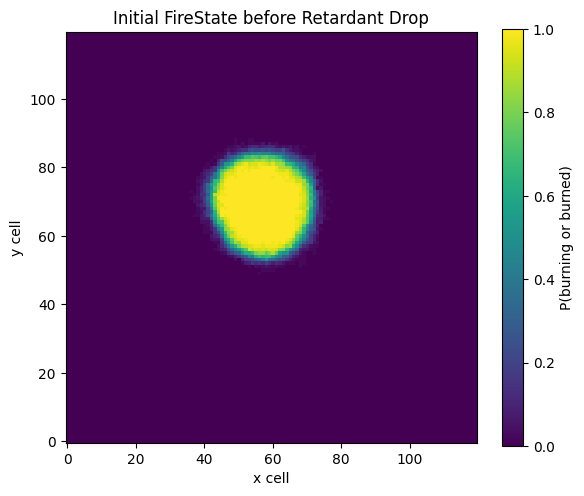

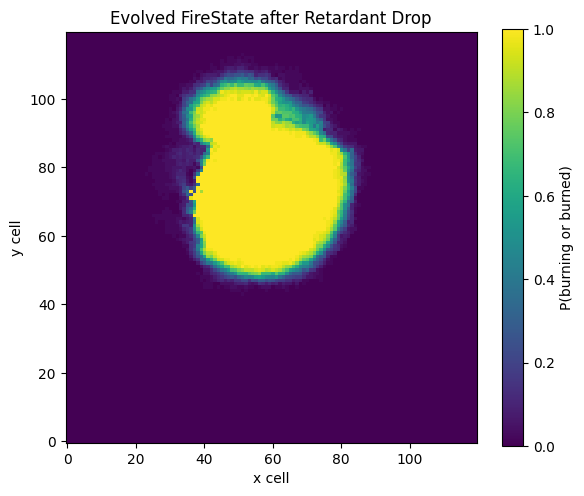

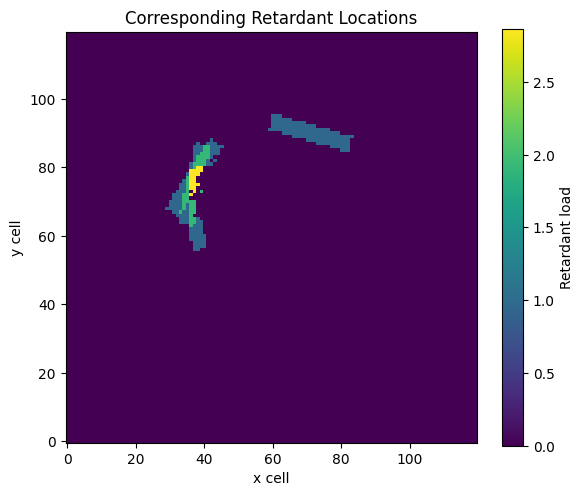

In [24]:
drop_opt.plot_evolved_firestate(
    theta=best_theta,
    n_sims=50,)

In [ ]:
search_mask, coords = drop_opt.setup_search_grid(K=300, boundary_field="affected")
best_theta, best_params, best_value, (X, y), y_nexts, y_bests = drop_opt.run_bayes_opt(
    n_init=80,
    n_iters=160,
    n_candidates=2**12, #note will still hit the Sobol balance property warning since Sobol used for global (so n_candidates*(1-candidate_local_frac) should be power of 2)
    xi=0.03,  # coefficient to encourage exploration
    verbose=True,
    init_strategy="heuristic",
    init_heuristic_random_frac=0.3, #% of initial points that are random (the rest are heuristic initialised)
    print_every=20,
    candidate_strategy="mixed",
    candidate_qmc="sobol",
    candidate_local_frac=0.65,
    candidate_local_top_k=5, 
    candidate_local_sigma_cells=4.0,
    candidate_local_sigma_phi_rad=np.deg2rad(20),
)

[BO] init: n_init=80, dim=12, n_cells=1284
[BO] init: best_y=7.91824, mean_y=10.2777, std_y=0.872977


/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)


[BO] iter 001/160 | y_next=9.32611 | best_y=7.91824 (no-improve) | EI_max=0.158 | mu=8.0828 | std=0.61
      proposed (x,y,phi) per drone:
      [[29.         80.          3.24938825]
 [41.         63.          3.70042302]
 [43.         91.          4.86899984]
 [53.         85.          4.39880748]]
      gp.kernel_ = 1.4**2 * TiedXYFiMatern(lx=0.219, ly=940, lphi=6.16, nu=2.5) + WhiteKernel(noise_level=0.228)


/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/qsp_env/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 0 of parameter k1__k2__lx is close to the specified upper bound 1000.0. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/Users/joshgreen/Documents/GitHub/PyroFinsler/fire_model/bo.py:276: UserWarning: The balance properties of Sobol' points require n to be a power of 2.
  X = sampler.random(n)
/opt/miniconda3/envs/q